In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim


import cv2
import numpy as np
import matplotlib.pyplot as plt

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet50 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load dataset
train_dataset = OxfordIIITPet(root='./data', download=True, split='trainval', transform=transform)
test_dataset = OxfordIIITPet(root='./data', download=True, split='test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc.requires_grad = True

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), 'resnet50_finetuned_oxfordiiitpet.pth')

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test dataset: {accuracy:.2f}%")


Epoch [1/10], Loss: 1.3541
Epoch [2/10], Loss: 0.3970
Epoch [3/10], Loss: 0.3023
Epoch [4/10], Loss: 0.2368
Epoch [5/10], Loss: 0.1990
Epoch [6/10], Loss: 0.1708
Epoch [7/10], Loss: 0.1528
Epoch [8/10], Loss: 0.1294
Epoch [9/10], Loss: 0.1133
Epoch [10/10], Loss: 0.1020
Accuracy on test dataset: 89.59%


In [19]:
# Save the entire model
torch.save(model, 'resnet50_oxfordiiitpet_full.pth')


In [54]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Hook for forward pass to get activations
        self.target_layer.register_forward_hook(self._save_activation_hook)

    def _save_activation_hook(self, module, input, output):
        self.activations = output

    def _get_gradients_hook(self, grad):
        self.gradients = grad

    def generate_cam(self, input_image, class_idx):
      # Forward pass
      output = self.model(input_image)
      self.model.zero_grad()

      # Attach hook to the gradients of the target layer
      self.activations.register_hook(self._get_gradients_hook)

      # Backward pass for the target class
      class_score = output[0, class_idx]
      class_score.backward()

      # Compute Grad-CAM
      gradients = self.gradients.detach().cpu().numpy()  # Detach from graph before converting to numpy
      activations = self.activations.detach().cpu().numpy()  # Detach from graph before converting to numpy
      weights = np.mean(gradients, axis=(2, 3))  # Average gradients spatially

      cam = np.zeros(activations.shape[2:], dtype=np.float32)
      for i, w in enumerate(weights[0]):
          cam += w * activations[0, i, :, :]

      cam = np.maximum(cam, 0)  # ReLU to keep only positive values
      cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
      cam -= np.min(cam)
      cam /= np.max(cam)
      return cam



In [43]:
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [51]:
# Ensure all parameters are frozen
for param in model.parameters():
    param.requires_grad = False

# Enable gradients for the target layer
for param in model.layer4[2].conv3.parameters():
    param.requires_grad = True


In [55]:
target_layer = model.layer4[2].conv3
grad_cam = GradCAM(model, target_layer)


37
Predicted Class: 0 - Abyssinian


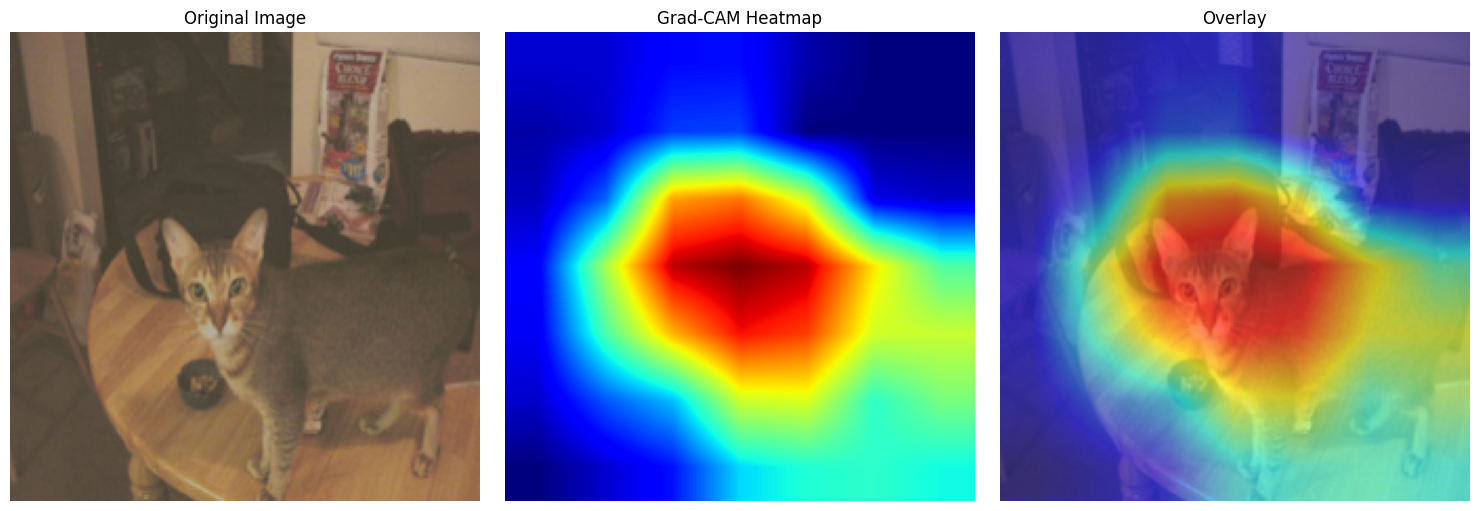

In [59]:
test_image, label = test_dataset[0]
test_image = test_image.unsqueeze(0).to(device)

# Get predicted class
output = model(test_image)
predicted_class = torch.argmax(output).item()


class_names = test_dataset.classes
print(len(class_names))# PyTorch ImageFolder datasets store class names in .classes
predicted_label = class_names[predicted_class]

# Display the predicted class
print(f"Predicted Class: {predicted_class} - {predicted_label}")

# Generate Grad-CAM
cam = grad_cam.generate_cam(test_image, predicted_class)
cam_image = cam.squeeze()

# Unnormalize the original image (if it was normalized during preprocessing)
original_image = test_image.squeeze(0).cpu().numpy()
original_image = np.transpose(original_image, (1, 2, 0))  # Convert to HWC format
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])  # ImageNet std
original_image = (original_image * std) + mean  # Unnormalize
original_image = np.clip(original_image, 0, 1)  # Clip to [0, 1] range

# Convert heatmap to RGB
heatmap = cv2.applyColorMap(np.uint8(255 * cam_image), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = np.float32(heatmap) / 255  # Normalize heatmap to [0, 1]

# Create overlay by blending the heatmap with the original image
overlay_image = heatmap + np.float32(original_image)
overlay_image = overlay_image / np.max(overlay_image)  # Normalize to [0, 1]

# Plot the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Grad-CAM Heatmap
plt.subplot(1, 3, 2)
plt.imshow(cam_image, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

# Overlay Image
plt.subplot(1, 3, 3)
plt.imshow(overlay_image)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()